# Visão dos dados e desafios

## Dicionário das colunas e dos dados:

Dados históricos da Ibovespa (BVSP), retidados do site [https://br.investing.com](https://br.investing.com/indices/bovespa-historical-data), considerando dados diários de cotações em um período entre **27/12/2000 à 22/08/2023**.
> *Data da Consulta: 22/08/2023*


*  **Data**: A data em que a negociação ocorreu.
*  **Abertura**: O preço pelo qual um ativo começou a ser negociado no dia em questão.
*  **Mínimo**: O menor preço atingido pelo ativo durante o dia de negociação.
*  **Máximo**: O preço mais alto atingido pelo ativo durante o dia de negociação.
*  **Volume** (Vol.): A quantidade total de ações (ou contratos) negociados durante o dia. Indica o interesse e a atividade dos investidores.
*  **Variação** (Var%): A diferença entre o preço de fechamento do dia atual e o preço de fechamento do dia anterior, geralmente expressa em porcentagem. Ela mostra a mudança no valor do ativo de um dia para o outro.



## Objetivos:

> Criar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

> Acurácia do modelo acima de 70%

# Pré-Processamento de dados

> Entendimento dos dados e colunas capturadas, assim como análises iniciais referentes às estatísticas básicas.

## Importação de bibliotecas e criação de funções gerais necessárias

In [343]:
# instalação de bilbiotecas necessárias
!pip install prophet pandas_ta statsforecast pyramid

In [547]:
# importanto as bibliotecas
import numpy as np
from numpy import mean
import math
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from scipy import stats
from datetime import date, time, datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA, AutoETS
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation # validação de métricas
from prophet.diagnostics import performance_metrics # validação de métricas

**Função para cálculo da mérica WMAPE**

In [345]:
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

## Importação da base e primeiras análises dos dados

In [346]:
from google.colab import drive # importar módulo do drive e upar base de dados pelo diretório
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [347]:
ibovespa_diario = pd.read_csv("drive/My Drive/Pos Tech Base de Dados/Tech Challenge Fase 2/Base de Dados/dados_ibovespa_dez00-ago23.csv", sep=",", parse_dates=[0], index_col="Data",dayfirst=True) # definição da coluna Data como index
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,"3,67M","-0,76%"
2019-12-27,116.534,117.205,117.803,115.995,"3,91M","-0,57%"
2019-12-26,117.203,115.864,117.220,115.673,"3,79M","1,16%"
2019-12-23,115.863,115.119,115.863,114.964,"4,00M","0,64%"
2019-12-20,115.121,115.133,115.171,114.526,"6,89M","-0,01%"


In [348]:
print("Range de datas:")
print(f"\tData inicial:",ibovespa_diario.index.min())
print(f"\tData final:",ibovespa_diario.index.max())

Range de datas:
	Data inicial: 2000-12-27 00:00:00
	Data final: 2023-08-22 00:00:00


In [349]:
total = ibovespa_diario.shape[0]
print("Total de dados na base: ", total)

Total de dados na base:  5611


In [350]:
ibovespa_diario.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5611 entries, 2019-12-30 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    5611 non-null   float64
 1   Abertura  5611 non-null   float64
 2   Máxima    5611 non-null   float64
 3   Mínima    5611 non-null   float64
 4   Vol.      5610 non-null   object 
 5   Var%      5611 non-null   object 
dtypes: float64(4), object(2)
memory usage: 306.9+ KB


Necessário realizar alguns pré-processamentos nos dados:
<!-- * Colunas "Último","Abertura", "Máxima", "Mínima": Ajustar casa decimal (valor em milhar) e alterar o type para int. -->

* Vol: retirar caracteres "K" e "M" e tratar valores

* Var%: Retirar caracter "%".

## Tratamento e pré-processamento de dados da base

In [352]:
# função para retirar caracteres não numericos da coluna Volume
def convert_volume(vol):
    if isinstance(vol, str):
        if 'M' in vol:
            return float(vol.replace('M', '')) * 1000000
        elif 'K' in vol:
            return float(vol.replace('K', '')) * 1000
    return vol

ibovespa_diario = ibovespa_diario.replace(",",".", regex = True) # Tudo que é vírgula vira ponto
ibovespa_diario['Var%'] = ibovespa_diario['Var%'].replace("%"," ", regex = True).astype(float) # Tudo que é vírgula vira ponto
ibovespa_diario['Vol.'] = ibovespa_diario['Vol.'].apply(convert_volume)
ibovespa_diario['Vol.'] = round(ibovespa_diario['Vol.'].astype(float))
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,3670000.0,-0.76
2019-12-27,116.534,117.205,117.803,115.995,3910000.0,-0.57
2019-12-26,117.203,115.864,117.220,115.673,3790000.0,1.16
2019-12-23,115.863,115.119,115.863,114.964,4000000.0,0.64
2019-12-20,115.121,115.133,115.171,114.526,6890000.0,-0.01


In [353]:
ibovespa_diario.dtypes # validação dos tipos de dados

Último      float64
Abertura    float64
Máxima      float64
Mínima      float64
Vol.        float64
Var%        float64
dtype: object

> Tratamento das colunas realizada, com exceção da coluna Vol. que ainda está em float. Ao fazer a transformação, ocorreu um erro sinalizando que existe um dado nulo nesta coluna.

### Identificação de dados nulos ou duplicados

In [354]:
val_duplicated = ibovespa_diario.duplicated().sum()

print("Validação de dados duplicados:")
if val_duplicated > 0:
  print(f"\tExistem valores duplicados na base, é necessário investigar.")
else:
  print(f"\tNão esxistem valores duplicados na base!")

Validação de dados duplicados:
	Não esxistem valores duplicados na base!


In [355]:
percent_nulos = 100*((ibovespa_diario.isnull().sum())/(len(ibovespa_diario))) # avaliação de dados nulos
print(percent_nulos)

Último      0.000000
Abertura    0.000000
Máxima      0.000000
Mínima      0.000000
Vol.        0.017822
Var%        0.000000
dtype: float64


Existem valores nulos na coluna Vol.

In [356]:
ibovespa_diario.loc[ibovespa_diario['Vol.'].isnull()]

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-10,40.377,40.592,40.592,39.96,NaN,-0.53


In [357]:
ibovespa_diario['Vol.'] = ibovespa_diario['Vol.'].fillna(value = 0) # alterando o valor nulo por 0
ibovespa_diario['Vol.'] = ibovespa_diario['Vol.'].astype(int) # transformação do tipo para inteiro
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,3670000,-0.76
2019-12-27,116.534,117.205,117.803,115.995,3910000,-0.57
2019-12-26,117.203,115.864,117.220,115.673,3790000,1.16
2019-12-23,115.863,115.119,115.863,114.964,4000000,0.64
2019-12-20,115.121,115.133,115.171,114.526,6890000,-0.01


Por fim, criação de uma coluna com o dia da semana para avaliarmos distribuição

In [358]:
def obter_dia_da_semana(data_index):
    try:
        data = datetime.strptime(data_index, '%d/%m/%Y')
        dias_da_semana = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
        dia_da_semana = dias_da_semana[data.weekday()]
        return dia_da_semana
    except ValueError:
        return "Data inválida"

ibovespa_diario['Dia_da_Semana'] = ibovespa_diario.index.map(lambda x: obter_dia_da_semana(x.strftime('%d/%m/%Y')))
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Dia_da_Semana
Data,,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,3670000,-0.76,Segunda-feira
2019-12-27,116.534,117.205,117.803,115.995,3910000,-0.57,Sexta-feira
2019-12-26,117.203,115.864,117.220,115.673,3790000,1.16,Quinta-feira
2019-12-23,115.863,115.119,115.863,114.964,4000000,0.64,Segunda-feira
2019-12-20,115.121,115.133,115.171,114.526,6890000,-0.01,Sexta-feira


## Análise exploratória dos dados

> Variáveis principais:
* ds = data
* y = Último - O preço de fechamento da bolsa no dia em questão

**Visão considerando toda série histórica (2000 a 2023)**

In [359]:
ibovespa_diario.describe().round(2)

,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,5611.00,5611.00,5611.00,5611.00,5.611000e+03,5611.00
mean,58.87,58.85,59.45,58.26,6.689736e+07,0.05
std,31.07,31.07,31.31,30.81,1.170886e+08,1.75
min,8.37,8.40,8.51,8.22,0.000000e+00,-14.78
25%,37.44,37.41,37.98,36.86,3.010000e+06,-0.88
50%,56.44,56.44,56.97,55.90,5.380000e+06,0.07
75%,74.46,74.42,75.14,73.79,9.910000e+07,1.03
max,130.78,130.78,131.19,129.53,9.949600e+08,14.66


**Inferências iniciais:**

* Média de preço de fechamento histórico em 58.87 e a mediana é de 56.44, aparentemente indicando que há poucos períodos com outliers.

* O desvio padrão é de 31.07, sendo um valor consideravelmente alto. Para os dados atuais, o desvio padrão pode indicar a **volatilidade do mercado**.
> Nosso desvio padrão médio representa 53% da média, indicando momentos de alta volatidade e fases de baixa.

* Apesar de não ser o target, podemos ver também uma dispersão alta entre valores mínimos e máximos, mostrando que houveram momentos significativos de queda e de alta ao longo dos 23 anos.

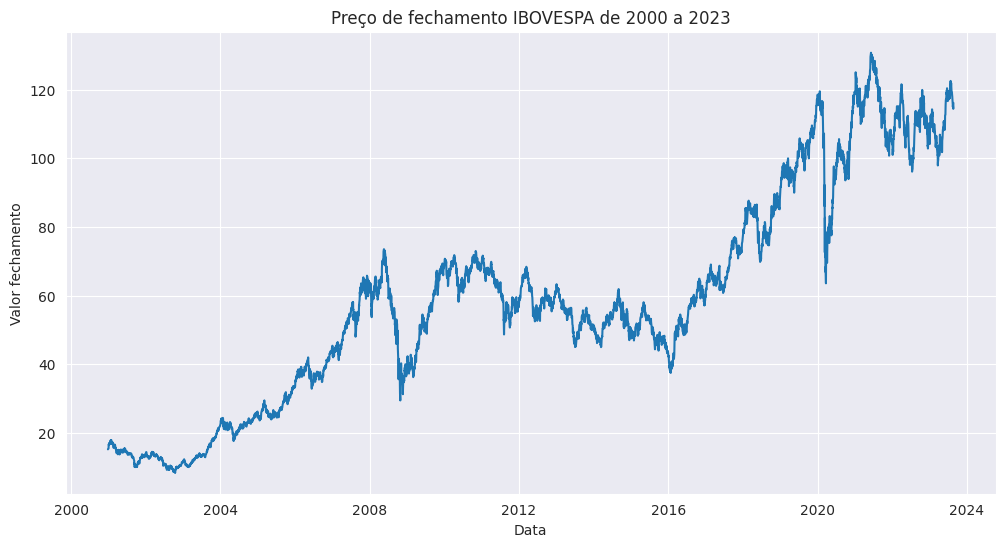

In [360]:
sns.set_style("darkgrid")
ibovespa_diario = ibovespa_diario.sort_index()

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(ibovespa_diario.index, ibovespa_diario.Último)
plt.xlabel('Data')  # Adiciona rótulo ao eixo x
plt.ylabel('Valor fechamento')  # Adiciona rótulo ao eixo y
plt.title('Preço de fechamento IBOVESPA de 2000 a 2023')
plt.show()

**Inferências iniciais sobre a dispersão dos dados ao longo do tempo:**

* Aparentemente, o preço de fechamento da bolsa aumenta ao longo dos anos, com maior amplitude após o ano de 2016.

* No momento atual (Agosto/2023), há um comportamento de leve queda em relação aos períodos anteriores.

* Nas quedas em 2008 e 2020, é possível perceber como fatores externos impactam diretamente na reação do mercado (possíveis outliers)
> **2008:** Os resultados da economia brasileira foram bastante influenciados pela crise financeira internacional em 2009, considerada como a maior crise econômica da história.

    > **2020**: Impacto da pandemia global do Coronavírus.

* Percebemos que os dados sofrem diversas variações ao longo do tempo, mas sem uma sazonalidade muito evidente, consequência da sensibilidade do dado para fotores externos ou incertezas de mercado.


**Análise de dados por dia da semana**

Objetivo: Qual a distrbuiçção por dia e existe uma sazonalidade diária?

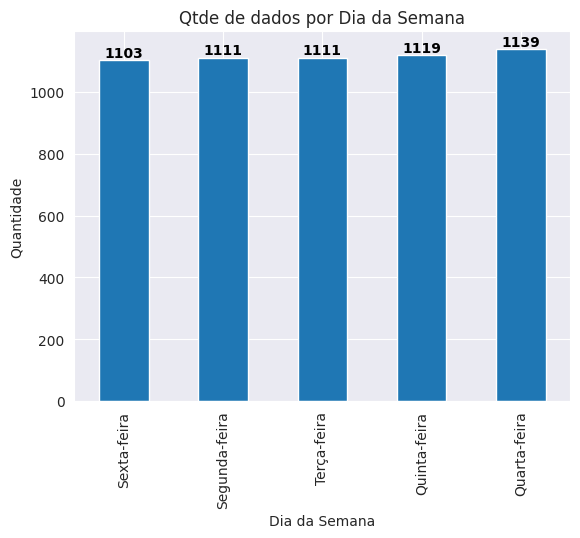

In [361]:
dados_dia = ibovespa_diario.groupby("Dia_da_Semana")["Último"].nunique()
dados_dia.sort_values(ascending=True, inplace=True)
# Criar o gráfico de barras
ax = dados_dia.plot(kind='bar')
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade')
plt.title('Qtde de dados por Dia da Semana')

# Adicionar valores como anotações nas barras
for idx, value in enumerate(dados_dia):
    ax.text(idx, value + 10, str(value), ha='center', color='black', fontweight='bold')

plt.show()

* Há uma concentração linear em relação dias da semana, com quarta-feria sendo o dia com maiores obsevarções desde o começo.

* Aqui, percebemos que o dados captados pela IBOVESPA são relacionados a dias úteis, sem presença de final de semana ou até mesmo feriados.

* Além disso, no gráfico abaixo percebemos que média de pontos do fechamento se mantem ao longo dos dias, sem indicações de fechamentos maiores em algum dia específico.

In [362]:
ibovespa_diario.groupby("Dia_da_Semana")["Último"].describe().round(2).T # avaliação das estatísticas por dia da semana

Dia_da_Semana,Quarta-feira,Quinta-feira,Segunda-feira,Sexta-feira,Terça-feira
count,1142.00,1122.00,1119.00,1110.00,1118.00
mean,58.92,59.01,58.80,58.78,58.84
std,31.03,31.18,31.13,31.09,30.98
min,8.37,8.87,8.45,8.72,8.51
25%,37.70,37.50,37.24,37.34,37.41
50%,56.46,56.79,56.49,56.49,56.24
75%,74.78,74.68,74.32,73.80,74.32
max,129.91,130.08,130.78,130.13,130.09


**Histograma e distribuição dos dados**

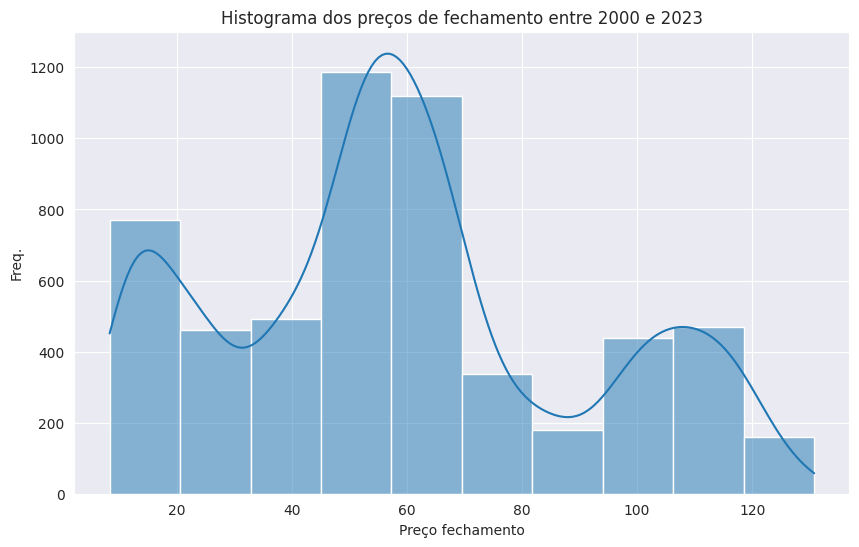

In [363]:
plt.figure(figsize=(10,6))
plot = ibovespa_diario.Último
sns.histplot(plot, bins=10, kde=True)
plt.xlabel('Preço fechamento')
plt.ylabel('Freq.')
plt.title('Histograma dos preços de fechamento entre 2000 e 2023')
plt.show()

A distribuição dos dados indica uma distribuição assimétrica á esquerda, indicando que há uma concentração maior de dados de fechamento até 60.

Pelo gráfico, entendemos que essa concentração de dados ocorre antes do ano de 2016, quando houve o maior crescimento.

### Análise das série temporal e seus componentes: processo de entendimento das características da série temporal da IBOVESPA e análises pertinentes:

* **Decomposição da serie temporal:** Análise dos componentes contidos na série que podem informar padrões de sazonalidade, tendência e amostras aleatórias (resíduos) da série.

* **Autocorrelação (ACF) e Parcial Autocorrelação (PACF): **Permite entender a estrutura temporal dos dados e as correlações diretas e indiretas sobre os períodos. Além de ajudar na modelagem de dados.

* Estacionariedade da série e teste de AdFuller: Uma série estacionária, em termos simples, é uma sequência de dados onde as médias e as características principais permanecem constantes ao longo do tempo, sem tendências claras de crescimento ou declínio. **Pode ser testada estatísticamente pelo Teste ADF (Augmented Dickey-Fuller)**

**Análise do Seasonal Decompose**

In [823]:
# configuralção da decomposição
dados_decompose = ibovespa_diario[['Último']]
dados_decompose = dados_decompose.dropna() # eliminar dados nulos
dados_decompose = dados_decompose.sort_index() # eliminar ordenar as datas em forma crescente

resultados = seasonal_decompose(dados_decompose, period=12, model='multiplicative') # O parâmetro “período” é o número de observações em um ciclo sazonal. 12 considerando a sazonalidade anual

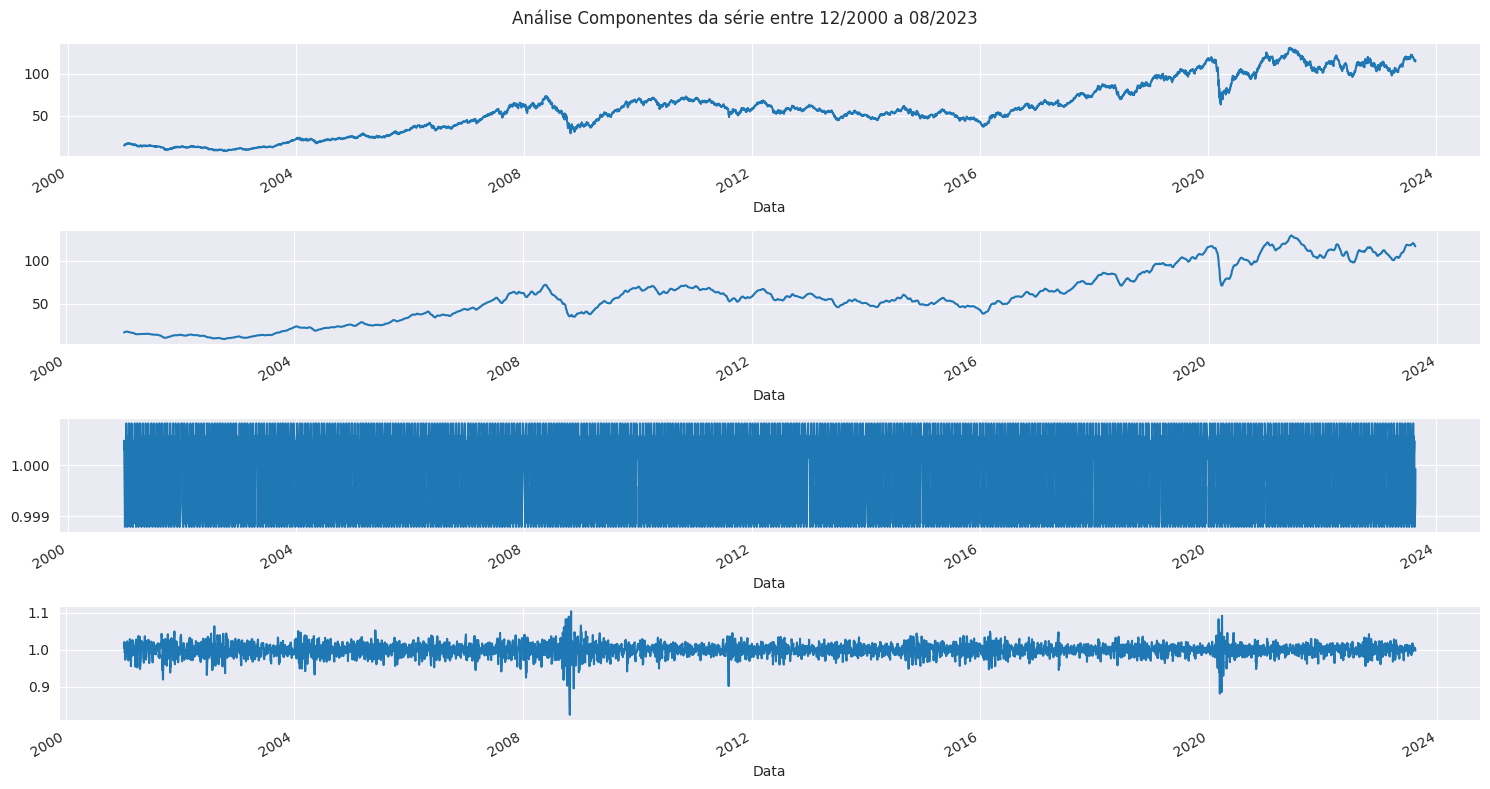

In [824]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,8))
plt.suptitle("Análise Componentes da série entre 12/2000 a 08/2023")
resultados.observed.plot(ax=ax1) # observação dos gráficos ao longo do tempo
resultados.trend.plot(ax=ax2) # tendência dos dados ao longo do tempo
resultados.seasonal.plot(ax=ax3) # sazonalidade / recorrencia dos dados
resultados.resid.plot(ax=ax4) # residuos que não necessariamente fazem sentido - IMPORTANTE AVALIAR

plt.tight_layout()
plt.show()

In [825]:
resultados.resid.to_frame().mean()

resid    0.999884
dtype: float64

> **Inferências iniciais dos gráficos**:

* Pelas análises de obervação e tendência, é possível visualizar um aumento do preço de fechamento ao longo dos anos, com tendência crescente, mas sem sazonalidade aparente.

* Em relação aos ruídos, temos também uma média próxima há 1, indicando que não se trata de um ruído branco (cuja expectativa é zero e possuem variância constante) e podem haver dados nesse componente que poderiam ser usados no nosso modelo.

**Relembrando a distribuição dos dados**

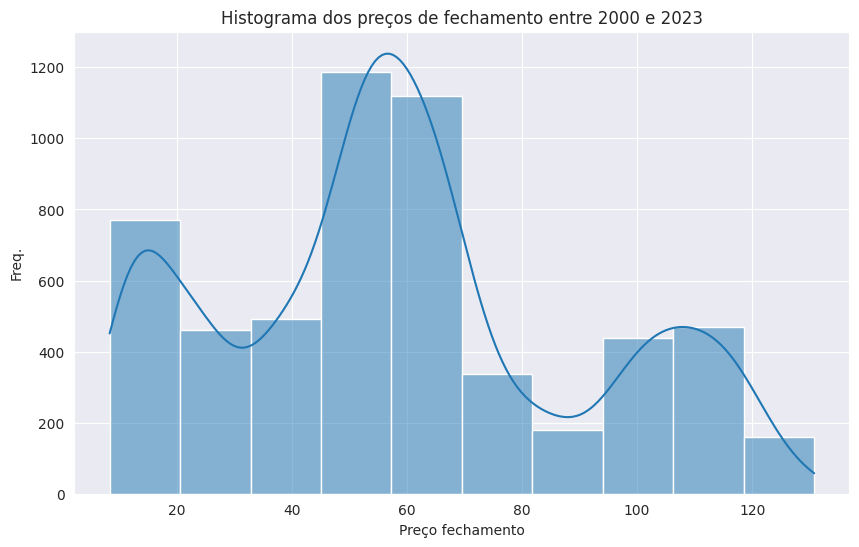

In [810]:
plt.figure(figsize=(10,6))
plot = ibovespa_diario.Último
sns.histplot(plot, bins=10, kde=True)
plt.xlabel('Preço fechamento')
plt.ylabel('Freq.')
plt.title('Histograma dos preços de fechamento entre 2000 e 2023')
plt.show()

* A distribuição aparentemente é assimétrica e não se comporta como uma normal. Vamos testar com o teste de Shapiro-Wilk para avaliação:

* Neste caso, indica a possibilidade no tratamento de dados para remover tendências e padrões sazonais, tornando a série mais estacionária.


In [811]:
from scipy.stats import norm, shapiro # teste de shapiro para análise
shapiro_test = ibovespa_diario['Último']
shapiro(shapiro_test)
alpha = 0.05 # definição da significancia

print(f"\tP-Value Shapiro: {shapiro(shapiro_test).pvalue}")

# avaliação final
print("\n\nAvaliação do p-value:")
if shapiro(shapiro_test).pvalue >= alpha:
  print(f"\tEstatisticamente, não podemos rejeitar a hipótese nula - Distribuiçaõ Normal")
else:
  print(f"\tRejeitar a hipótese nula - Diferente de uma distribuição normal.")


	P-Value Shapiro: 6.938094943580391e-39


Avaliação do p-value:
	Rejeitar a hipótese nula - Diferente de uma distribuição normal.


Análise ACF e PACF

Objetivo: Determinar os coeficientes dos modelos de série temporal, além de ajudar a identificar sazonalide e tendência.

**ACF:** Demonstra como um valor em uma série temporal (t-1) se relaciona com outros valores em pontos de tempo anteriores.

**PACF:** Nos ajuda a calcular a correlação direta entre os dois dias, ignorando a influência dos dias intermediários.



> A função de autocorrelação (ACF) nos dará as possíveis ordens do componente de médias móveis (MA) e a função de autocorrelação parcial nos dará as possíveis ordens do compoenente autorregressivo (AR)


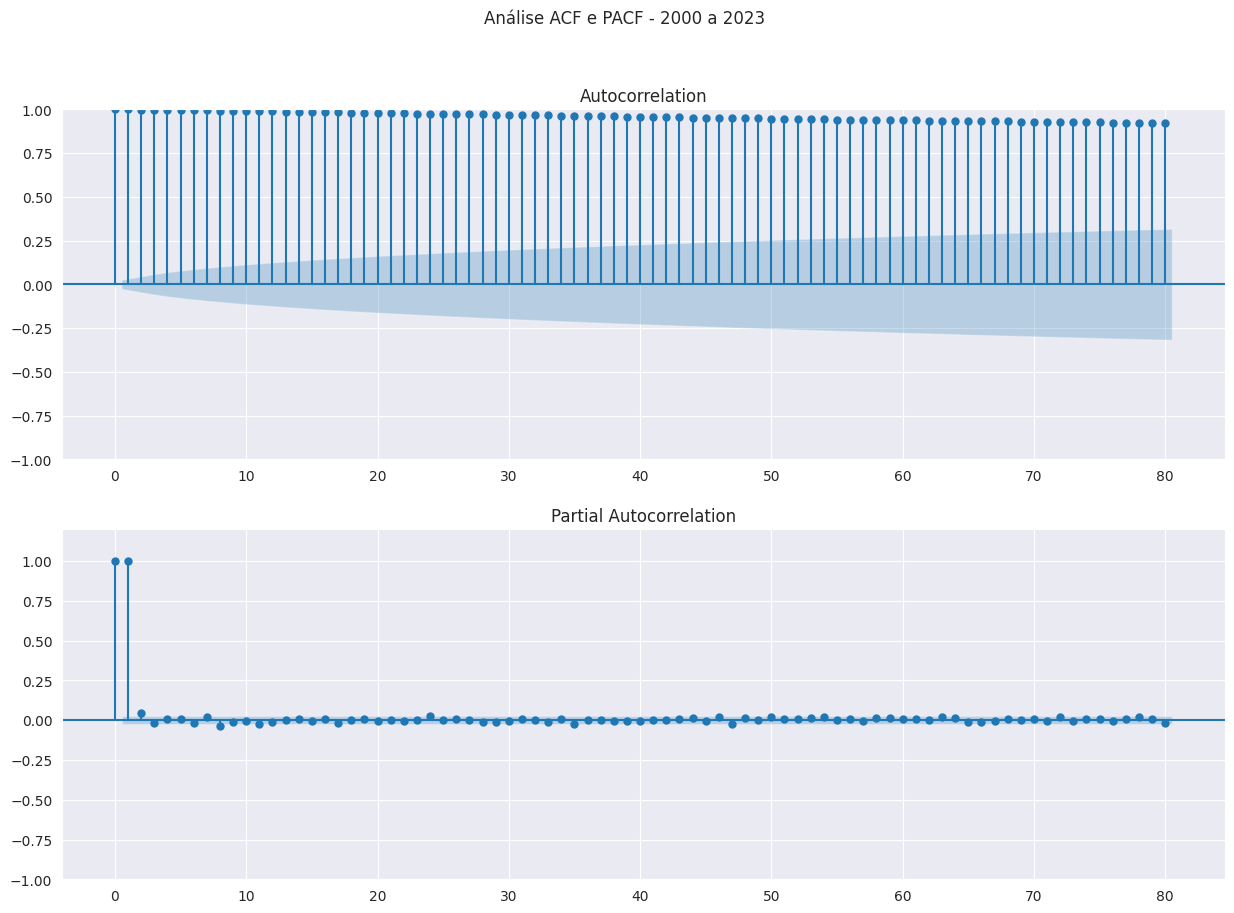

In [814]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,10))
plt.suptitle("Análise ACF e PACF - 2000 a 2023")
plot_acf(ibovespa_diario.Último, ax=ax1, lags=80)
plot_pacf(ibovespa_diario.Último, ax=ax2, lags=80)
plt.ylim(-1,1.2)
# plt.tight_layout()
plt.show()

A autocorrelação entre as séries ocorre de **forma lenta**, indicando que a série é não estacionária e que há uma dependência temporal nas observações da série (necessário uma diferenciação - ordem d =! 0).

No gráfico abaixo com um maior período de autocorrelação, é possível identificar que o **caimento ocorre somente após 1.250 períodos**.

Já no PACF temos uma autocorrelação forte nos 2 primeiros lags, podendo inferir um AR (p) de ordem 2.


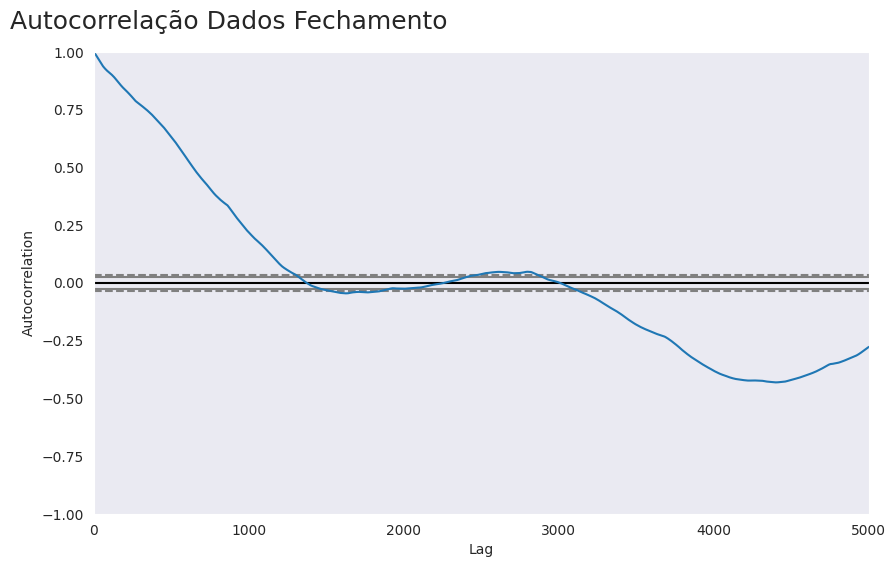

In [819]:
from pandas.plotting import autocorrelation_plot
ax = plt.figure(figsize=(10,6))
ax.suptitle('Autocorrelação Dados Fechamento', fontsize=18, x=0.26, y=0.95)
autocorrelation_plot(ibovespa_diario.Último).set_xlim([0, 5000])
ax = ax

**Análise do Teste AdFuller para chechar estacionaridade da base de dados**

    H0 -> Série não estacionária (p-value > 0.05)
    H1 -> Série estacionária (p-value <= 0.05)

* **p-value > 0.05**: Falha para rejeitar a hipotese nula (h0) a série é não estacionária.

* **p-value ≤ 0.05**: Rejeita a hipotese nula (H0), a série é estacionária.

In [826]:
x = ibovespa_diario.Último.values  # transformação dos dados em variável
results = adfuller(x)# configuração do teste
alpha = 0.05 # definição da significancia

# print das métricas do teste
print("Teste ADF - Dados pós 2011")
print(f"\tTeste Estatístico: {results[0]}")
print(f"\tP-Value: {results[1]}")
print("\tValores críticos:")

for key, value in results[4].items():
  print(f"\t\t{key}: {value}")

# avaliação final
print("\n\nAvaliação do p-value:")
if results[1] >= alpha:
  print(f"\tEstatisticamente, não podemos rejeitar a hipótese nula - Série Não Estacionária")
else:
  print(f"\tRejeitar a hipótese nula - Série Estacionária.")


Teste ADF - Dados pós 2011
	Teste Estatístico: -1.0113062272035385
	P-Value: 0.7491183101869306
	Valores críticos:
		1%: -3.4315184766153255
		5%: -2.8620563524707463
		10%: -2.567044852955301


Avaliação do p-value:
	Estatisticamente, não podemos rejeitar a hipótese nula - Série Não Estacionária
